# Experiment Run

Information Geometry Soft Clustering for Sport Analytics

Joaquin Garay

In [6]:
%load_ext autoreload
%autoreload 2

import os
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import vis
import softclustering as sc
import socceraction.spadl as spadl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [7]:
datafolder = "data"
fifa2018h5 = os.path.join(datafolder, "spadl-fifa2018.h5")
games = pd.read_hdf(fifa2018h5, key="games")
with pd.HDFStore(fifa2018h5) as store:
    actions = []  #list of DataFrames
    for game in tqdm(games.itertuples()):
        game_action = store[f"actions/game_{game.game_id}"]
        game_action = spadl.play_left_to_right(game_action, game.home_team_id)
        game_action["is_home"] = game_action["team_id"] == game.home_team_id
        actions.append(game_action)
    actions = pd.concat(actions)
    actions.drop("original_event_id", axis=1, inplace=True)
    actions = pd.merge(actions, spadl.config.actiontypes_df(), how="left")
    actions = sc.consolidate(actions)
    actions = sc.add_noise(actions)
    actions = sc.remove_outliers(actions, True)
    actions["angle"] = np.arctan2(actions.end_y - actions.start_y, actions.end_x - actions.start_x)
    actions["cos_angle"] = np.cos(actions["angle"])
    actions["sin_angle"] = np.sin(actions["angle"])



64it [00:00, 203.07it/s]


Remove 533 out of 128484 datapoints.


## Experiment

There are 10 action types that are to be clustered using Gaussian mixture distribution. Some of the actions have not and end location, thus are not relevant for this research because we cannot compute their direction. Also the action "shot_penalty" always has the same start location, so no need to cluster them.

In [9]:
# select actions type to run location soft clustering
# shot penalty has always the same starting point
no_dir_action_types = set(actions[actions["angle"] == 0.0]["type_name"])
action_types = set(actions["type_name"]) - no_dir_action_types - {"shot_penalty"}
action_types

{'clearance',
 'corner',
 'cross',
 'dribble',
 'freekick',
 'goalkick',
 'keeper_action',
 'pass',
 'shot',
 'throw_in'}

### Location mixture: Number of clusters calibration

We look for the optimal number of location clusters for each action type based on a modified Calinski–Harabasz index for soft clustering.
$$CH = \frac{BC/(K-1)}{WC/(N-K)},$$
where between-cluster distance ($BC$) and within-cluster distance ($WC$) are defined as:
$$BC = \min_{\bar{\eta}}\sum_{j=1}^K \pi_j D_{\phi}[\eta_j : \bar{\eta}], \quad WC = -\sum_{i=1}^N\sum_{j=1}^K \ln (f(x_i|\theta_j)\cdot \pi_j) \, P(C_j|x_i).$$

In [18]:
rows = []
for action_type in action_types:
    print(f"\nProcessing {action_type}:")
    mask = (actions["type_name"] == action_type)  #& (actions["team_id"] == 771)
    loc_data = actions[mask][["start_x", "start_y"]]

    for model in ["classic"]:
        print(f" {model}", end="")
        for init_method in ["k-means"]:
            for K in range(2, 6):
                print(f" {K} clus.,", end="")
                gauss_clusters = [sc.MultivariateGaussian() for _ in range(K)]

                start = time()
                loc_model = sc.MixtureModel(gauss_clusters,
                                            init=init_method)
                loc_model.fit_em(loc_data, verbose=False, case=model)
                end = time() - start

                rows.append({
                    "action_type": action_type,
                    "model" : model,
                    "initialization":init_method,
                    "cluster_nbr": K,
                    "ch_score": round(loc_model.kl_ch_score(loc_data), 5),
                    "bic_score": round(loc_model.bic_score(loc_data), 0),
                    "aic_score": round(loc_model.aic_score(loc_data), 0),
                    "running_time": round(end,3)
                })

loc_scores = pd.DataFrame(rows)


Processing cross:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,
Processing freekick:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,
Processing corner:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,
Processing dribble:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,
Processing keeper_action:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,
Processing shot:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,
Processing throw_in:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,
Processing goalkick:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,
Processing pass:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,
Processing clearance:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,

In [13]:
loc_scores.sort_values(by=["action_type","ch_score"], ascending=[True,False], inplace=True)
loc_scores

,action_type,model,initialization,cluster_nbr,ch_score,bic_score,aic_score,running_time
144,clearance,bregman,k-means,2,0.23956,27515.0,27442.0,0.151
148,clearance,bregman,k-means++,2,0.23956,27515.0,27442.0,0.166
152,clearance,classic,k-means,2,0.23956,27515.0,27442.0,0.140
156,clearance,classic,k-means++,2,0.23956,27515.0,27442.0,0.152
146,clearance,bregman,k-means,4,0.15771,27410.0,27259.0,0.820
...,...,...,...,...,...,...,...,...
108,throw_in,classic,k-means++,2,542.43255,25540.0,25466.0,0.008
97,throw_in,bregman,k-means,3,269.74123,25399.0,25286.0,0.487
101,throw_in,bregman,k-means++,3,269.74123,25399.0,25286.0,0.393
105,throw_in,classic,k-means,3,269.74123,25399.0,25286.0,0.426


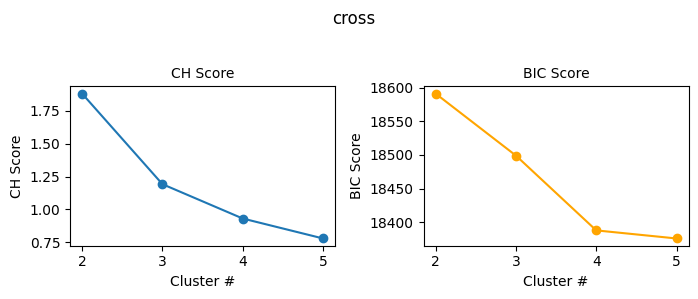

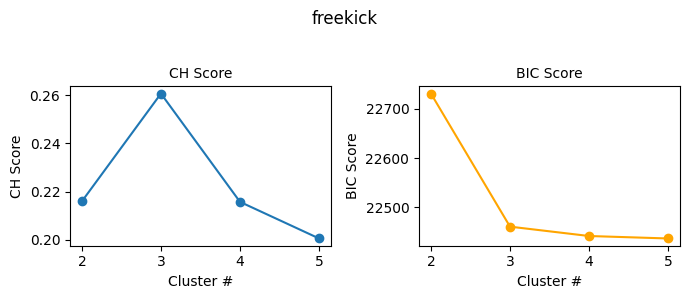

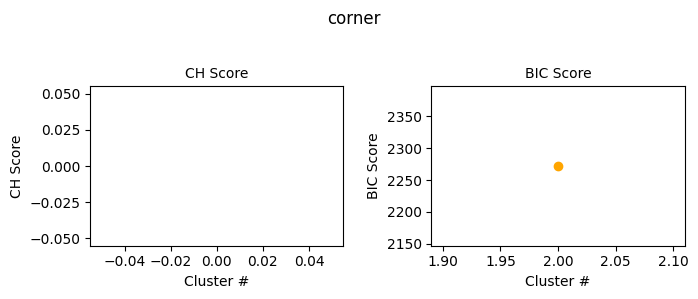

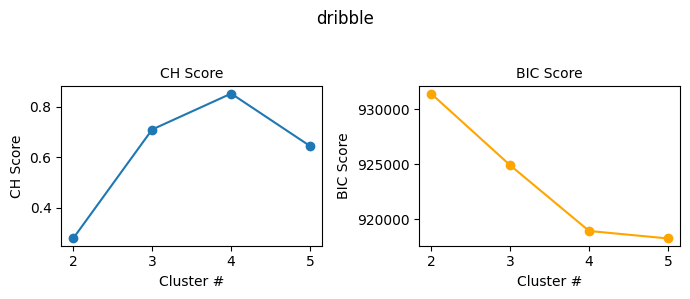

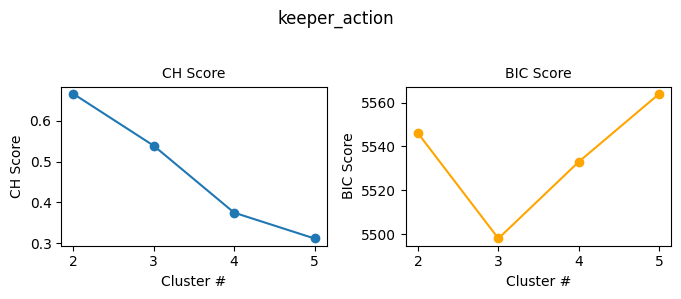

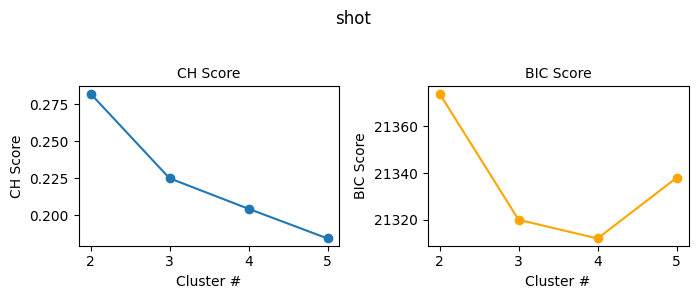

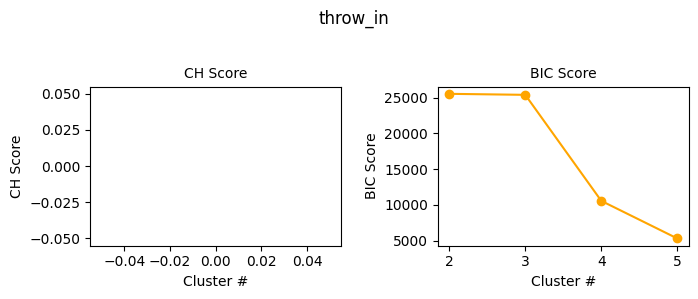

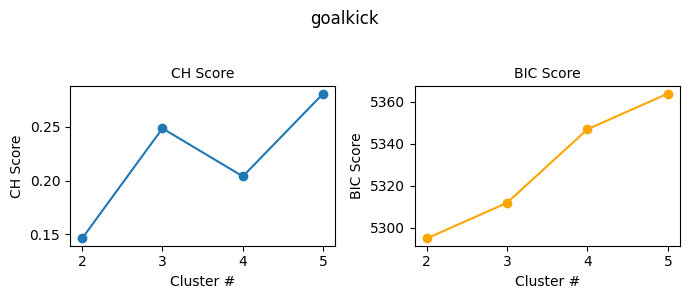

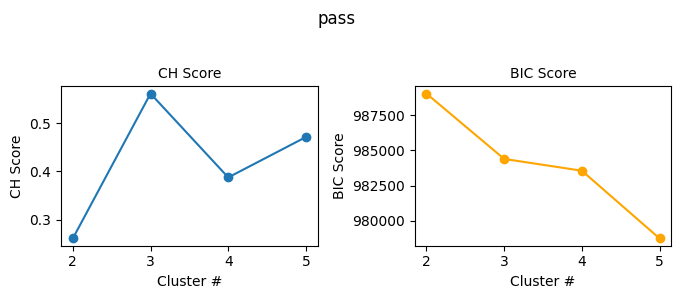

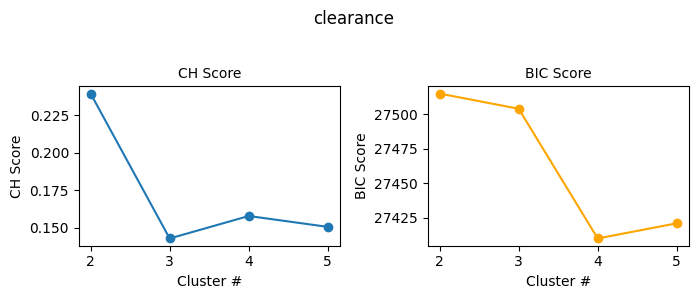

In [21]:
# Filter CH scores
#loc_scores.reset_index(inplace=True)
loc_scores_filtered = loc_scores[(loc_scores["ch_score"] <= 2) &
                                 (loc_scores["ch_score"] > 0) &
                                 (loc_scores["model"]=="classic") &
                                 (loc_scores["initialization"]=="k-means") ]

# Loop through each action_type and make a (1,2) plot per type
for action_type in action_types:
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))
    fig.suptitle(f"{action_type}", fontsize=12)

    # CH Score subplot
    ch_data = loc_scores_filtered[loc_scores_filtered["action_type"] == action_type]
    axes[0].plot(ch_data["cluster_nbr"], ch_data["ch_score"], marker="o")
    axes[0].set_title("CH Score", fontsize=10)
    axes[0].set_xlabel("Cluster #")
    axes[0].set_ylabel("CH Score")

    # BIC Score subplot
    bic_data = loc_scores[(loc_scores["action_type"] == action_type) & (loc_scores["bic_score"] > 0)]
    axes[1].plot(bic_data["cluster_nbr"], bic_data["bic_score"], marker="o", color="orange")
    axes[1].set_title("BIC Score", fontsize=10)
    axes[1].set_xlabel("Cluster #")
    axes[1].set_ylabel("BIC Score")

    plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))
    plt.show()

In [22]:
optimal_loc_K = {
    f"{action_type}": group.loc[group["ch_score"].idxmax(), "cluster_nbr"]
    for action_type, group in loc_scores_filtered.groupby("action_type")
}
optimal_loc_K

{'clearance': 2,
 'cross': 2,
 'dribble': 4,
 'freekick': 3,
 'goalkick': 5,
 'keeper_action': 2,
 'pass': 3,
 'shot': 2}

In [27]:
optimal_loc_K = {
    'clearance': 2, # check
    'cross': 3, # manually added
    'dribble': 4, # check
    'freekick': 3, # check
    'goalkick': 3, # manually added
    'keeper_action': 3, # manually added
    'pass': 5, # manually added
    'shot': 2, # check
    'throw_in': 2,  # manually added
    'corner': 2  # manually added
}

In [28]:
loc_models = {}
for action_type in action_types:
    print(f"Processing {action_type}...")
    mask = (actions["type_name"] == action_type)
    loc_data = actions[mask][["start_x", "start_y"]]
    loc_K = optimal_loc_K[action_type]
    gauss_clusters = [sc.MultivariateGaussian() for _ in range(loc_K)]
    loc_model = sc.MixtureModel(gauss_clusters,
                                init='k-means')
    _ = loc_model.fit_em(loc_data, case="bregman")
    loc_models[action_type] = loc_model

Processing cross...
Processing freekick...
Processing corner...
Processing dribble...
Processing keeper_action...
Processing shot...
Processing throw_in...
Processing goalkick...
Processing pass...
Processing clearance...


In [29]:
print(loc_models["pass"])

MixtureModel(n_components=5)
  ├─ (0) w=0.072  MultivariateGaussian(d=2, mean=[56.527 64.882], cov=[[426.157  -0.108], [-0.108  1.87 ]])
  ├─ (1) w=0.391  MultivariateGaussian(d=2, mean=[52.845 20.168], cov=[[407.568 -32.149], [-32.149  85.433]])
  ├─ (2) w=0.390  MultivariateGaussian(d=2, mean=[52.934 48.95 ], cov=[[411.9    26.426], [26.426 75.67 ]])
  ├─ (3) w=0.066  MultivariateGaussian(d=2, mean=[16.508 32.933], cov=[[58.263 -5.689], [ -5.689 217.448]])
  └─ (4) w=0.080  MultivariateGaussian(d=2, mean=[57.044  3.32 ], cov=[[415.019  -1.562], [-1.562  2.514]])


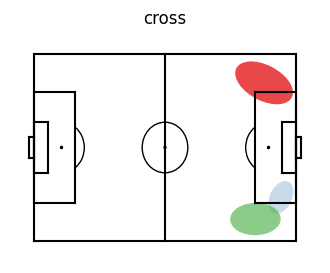

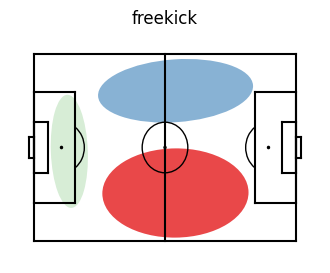

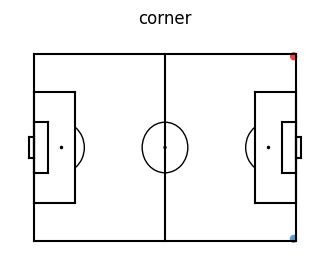

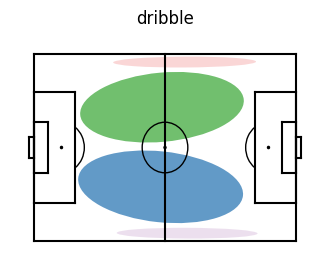

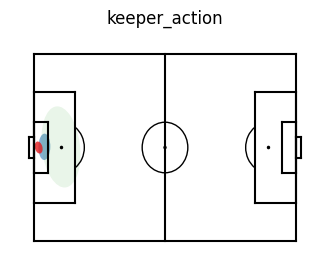

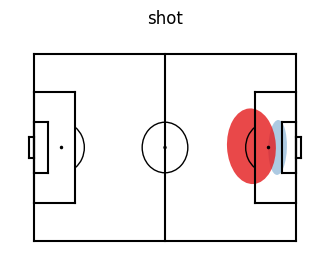

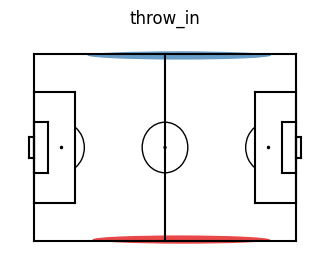

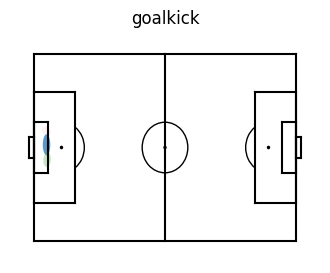

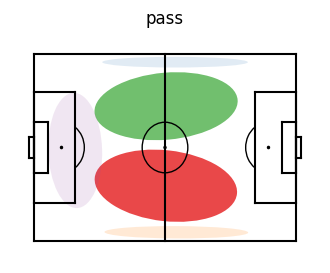

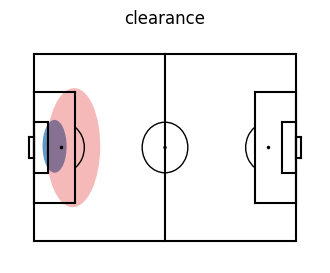

In [30]:
for action_type in action_types:
    vis.show_location_model(loc_models[action_type], figsize=4, title=action_type)

### Direction mixture: Number of cluster calibration

Similarly, we continue searching for the optimal number of cluster for the direction mixture mddel. In this case, we model a von Mises mixture distribution for each location cluster for each action type. The direction data is the full dataset as before, but weighted by the location posteriors probabilities of each cluster.

In [34]:
# takes around 22 minutes. Results are saved in data/dir_optimal_clusters.csv
rows = []
for action_type in action_types:
    print(f"\nProcessing {action_type}:")
    mask = (actions["type_name"] == action_type)
    loc_data = actions[mask][["start_x", "start_y"]]
    dir_data = actions[mask][["cos_angle", "sin_angle"]]
    N = loc_data.shape[0]
    loc_model = loc_models[action_type]
    K_loc = loc_model.n_components
    # first layer posterior is fixed
    loc_posteriors = loc_model.get_posteriors(loc_data)
    for case in ["bregman", "classic", "approximation"]:
        print(f"   Approach: {case}")
        for loc_cluster in range(K_loc):
            print(f"      Location cluster: {loc_cluster}\n         ", end="")
            for K_dir in range(2, 6):
                print(f"K={K_dir}, ", end="")
                start = time()
                dir_mixture = sc.MixtureModel([sc.VonMises() for _ in range(K_dir)],
                                              weights=None,
                                              init="k-means")
                _ = dir_mixture.fit_em(dir_data,
                                       sample_weight=loc_posteriors[:, loc_cluster],
                                       case=case)
                end = time() - start

                rows.append({
                    "action_type": action_type,
                    "loc_cluster": loc_cluster,
                    "cluster_nbr": K_dir,
                    "model": case,
                    "ch_score": round(dir_mixture.kl_ch_score(dir_data), 5),
                    "bic_score": round(dir_mixture.bic_score(dir_data), 0),
                    "aic_score": round(dir_mixture.aic_score(dir_data), 0),
                    "running_time": round(end, 3)
                })
            print("")

dir_scores = pd.DataFrame(rows)



Processing cross:
   Approach: bregman
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 
      Location cluster: 2
         K=2, K=3, K=4, K=5, 
   Approach: classic
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 
      Location cluster: 2
         K=2, K=3, K=4, K=5, 
   Approach: approximation
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 
      Location cluster: 2
         K=2, K=3, K=4, K=5, 

Processing freekick:
   Approach: bregman
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 
      Location cluster: 2
         K=2, K=3, K=4, K=5, 
   Approach: classic
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 
      Location cluster: 2
         K=2, K=3, K=4, K=5, 
   Appro

In [54]:
dir_scores

,action_type,loc_cluster,cluster_nbr,model,ch_score,bic_score,aic_score,running_time
0,cross,0,2,bregman,0.00000,23666.0,23651.0,0.026
1,cross,0,3,bregman,0.00000,23674.0,23653.0,0.023
2,cross,0,4,bregman,0.00000,23681.0,23655.0,0.035
3,cross,0,5,bregman,0.00000,23688.0,23657.0,0.030
4,cross,1,2,bregman,0.00638,22050.0,22035.0,0.262
...,...,...,...,...,...,...,...,...
343,clearance,0,5,approximation,0.14910,6140.0,6107.0,0.388
344,clearance,1,2,approximation,0.07194,6197.0,6180.0,0.131
345,clearance,1,3,approximation,0.07835,6185.0,6162.0,0.358
346,clearance,1,4,approximation,0.09255,6167.0,6139.0,0.421


In [55]:
best_scores = dir_scores.loc[
    dir_scores.groupby(["action_type", "loc_cluster", "model"])["ch_score"].idxmax()
]
optimal_dir_K = best_scores[["action_type", "loc_cluster", "model", "cluster_nbr"]]
optimal_dir_K.reset_index(drop=True, inplace=True)
best_scores.sort_values(by=["action_type", "loc_cluster", "ch_score"], ascending=[True, True, False], inplace=True)
best_scores

,action_type,loc_cluster,cluster_nbr,model,ch_score,bic_score,aic_score,running_time
341,clearance,0,3,approximation,0.23672,6131.0,6109.0,0.370
332,clearance,0,2,classic,0.22031,6158.0,6141.0,0.844
324,clearance,0,2,bregman,0.21867,6157.0,6140.0,0.365
337,clearance,1,3,classic,0.13325,6162.0,6139.0,1.322
347,clearance,1,5,approximation,0.12784,6196.0,6162.0,0.473
...,...,...,...,...,...,...,...,...
204,throw_in,0,2,bregman,0.26034,11572.0,11554.0,0.040
212,throw_in,0,2,classic,0.26033,11593.0,11576.0,0.087
224,throw_in,1,2,approximation,0.27010,12121.0,12104.0,0.019
208,throw_in,1,2,bregman,0.26956,11631.0,11614.0,0.020


In [56]:
optimal_dir_K.to_csv("data/dir_optimal_clusters.csv", index=False)

In [57]:
optimal_dir_K = pd.read_csv("data/dir_optimal_clusters.csv")

In [75]:
optimal_dir_K

,action_type,loc_cluster,model,cluster_nbr
0,clearance,0,approximation,3
1,clearance,0,bregman,2
2,clearance,0,classic,2
3,clearance,1,approximation,5
4,clearance,1,bregman,3
...,...,...,...,...
82,throw_in,0,bregman,2
83,throw_in,0,classic,2
84,throw_in,1,approximation,2
85,throw_in,1,bregman,2


In [76]:
 # Run using optimal number of clusters. Takes around 15 minutes.
experiment = {}
rows = []
for method in ["bregman", "approximation", "classic"]:
    for init in ["k-means++", "k-means", "random", "random_from_data"]:
        dir_models = {}
        for action_type in action_types:
            mask = (actions["type_name"] == action_type)
            loc_data = actions[mask][["start_x", "start_y"]]
            dir_data = actions[mask][["cos_angle", "sin_angle"]]
            #N = loc_data.shape[0]
            loc_model = loc_models[action_type]
            K_loc = loc_model.n_components
            # first layer posterior is fixed
            loc_posteriors = loc_model.get_posteriors(loc_data)
            mixture_list = []
            for loc_cluster in range(K_loc):
                K_dir = optimal_dir_K[
                    (optimal_dir_K["action_type"] == action_type) &
                    (optimal_dir_K["loc_cluster"] == loc_cluster) &
                    (optimal_dir_K["model"] == method)]["cluster_nbr"].item()
                start = time()
                dir_mixture = sc.MixtureModel([sc.VonMises() for _ in range(K_dir)],
                                              weights=None,
                                              init=init)
                _ = dir_mixture.fit_em(dir_data,
                                       sample_weight=loc_posteriors[:, loc_cluster],
                                       case=method)
                end = round(time() - start, 3)
                mixture_list.append(dir_mixture)
                ch_score = round(dir_mixture.kl_ch_score(dir_data), 5)
                bic_score = round(dir_mixture.bic_score(dir_data), 0)
                aic_score = round(dir_mixture.aic_score(dir_data), 0)
                row = {
                    "action_type": action_type,
                    "loc_cluster": loc_cluster,
                    "model": method,
                    "initialization": init,
                    "n_components": K_dir,
                    "ch_score": ch_score,
                    "bic_score": bic_score,
                    "aic_score": aic_score,
                    "running_time": end
                }
                print(
                    f" {action_type}, {loc_cluster}, {method}, {init}, {K_dir}, {ch_score}, {bic_score}, {aic_score}, Time: {end}s ")
                rows.append(row)

            dir_models[action_type] = mixture_list
        experiment[method + "," + init] = dir_models

experiment_df = pd.DataFrame(rows)

 cross, 0, bregman, k-means++, 2, 0.0, 23666.0, 23651.0, Time: 0.021s 
 cross, 1, bregman, k-means++, 2, 0.00638, 22050.0, 22035.0, Time: 0.29s 
 cross, 2, bregman, k-means++, 2, 0.0, 22313.0, 22298.0, Time: 0.015s 
 freekick, 0, bregman, k-means++, 3, 0.13727, 5065.0, 5045.0, Time: 0.274s 
 freekick, 1, bregman, k-means++, 5, 0.10627, 4610.0, 4579.0, Time: 0.284s 
 freekick, 2, bregman, k-means++, 3, 0.10688, 5520.0, 5499.0, Time: 0.24s 
 corner, 0, bregman, k-means++, 2, 0.06884, 6406.0, 6393.0, Time: 0.005s 
 corner, 1, bregman, k-means++, 2, 0.0603, 6823.0, 6810.0, Time: 0.007s 
 dribble, 0, bregman, k-means++, 4, 0.08019, 188491.0, 188446.0, Time: 13.71s 
 dribble, 1, bregman, k-means++, 2, 0.16557, 198620.0, 198594.0, Time: 6.646s 
 dribble, 2, bregman, k-means++, 4, 0.06481, 188567.0, 188523.0, Time: 13.888s 
 dribble, 3, bregman, k-means++, 2, 0.15102, 199327.0, 199300.0, Time: 8.759s 
 keeper_action, 0, bregman, k-means++, 2, 0.07321, 2159.0, 2146.0, Time: 0.219s 
 keeper_acti

In [79]:
experiment_df.to_csv("data/direction_clustering_results.csv",index=False)
experiment_df

,action_type,loc_cluster,model,initialization,n_components,ch_score,bic_score,aic_score,running_time
0,cross,0,bregman,k-means++,2,0.00000,23666.0,23651.0,0.021
1,cross,1,bregman,k-means++,2,0.00638,22050.0,22035.0,0.290
2,cross,2,bregman,k-means++,2,0.00000,22313.0,22298.0,0.015
3,freekick,0,bregman,k-means++,3,0.13727,5065.0,5045.0,0.274
4,freekick,1,bregman,k-means++,5,0.10627,4610.0,4579.0,0.284
...,...,...,...,...,...,...,...,...,...
343,pass,2,classic,random_from_data,2,0.14512,206735.0,206708.0,8.431
344,pass,3,classic,random_from_data,5,0.09333,215902.0,215848.0,25.431
345,pass,4,classic,random_from_data,2,0.21738,264767.0,264740.0,10.097
346,clearance,0,classic,random_from_data,2,0.22031,6158.0,6141.0,0.922


In [107]:
dir_summary = experiment_df.groupby(["action_type", "model", "initialization"]).agg({"ch_score": "sum",
                                                                                     "loc_cluster": "count",
                                                                                     "n_components": "sum",
                                                                                     "bic_score": "sum",
                                                                                     "aic_score": "sum",
                                                                                     "running_time": "sum"})
dir_summary = dir_summary.reset_index()
dir_summary["ch_score"] = dir_summary["ch_score"].round(5)
dir_summary["running_time"] = dir_summary["running_time"].round(2)
dir_summary.rename(columns={"loc_cluster": "count_loc_clusters",
                            "n_components": "count_dir_clusters"},
                   inplace=True)
dir_summary.sort_values(by=["action_type", "ch_score"],
                        ascending=[True, False],
                        inplace=True)

In [108]:
dir_summary

,action_type,model,initialization,ch_score,count_loc_clusters,count_dir_clusters,bic_score,aic_score,running_time
0,clearance,approximation,k-means,0.36456,2,8,12327.0,12271.0,0.94
1,clearance,approximation,k-means++,0.36456,2,8,12327.0,12271.0,0.89
3,clearance,approximation,random_from_data,0.36456,2,8,12327.0,12271.0,0.98
10,clearance,classic,random,0.35361,2,5,12320.0,12280.0,2.40
8,clearance,classic,k-means,0.35356,2,5,12320.0,12280.0,2.29
...,...,...,...,...,...,...,...,...,...
115,throw_in,bregman,random_from_data,0.52990,2,4,23203.0,23168.0,0.13
116,throw_in,classic,k-means,0.52970,2,4,23260.0,23226.0,0.26
117,throw_in,classic,k-means++,0.52970,2,4,23260.0,23226.0,0.28
118,throw_in,classic,random,0.52970,2,4,23260.0,23226.0,0.21


In [141]:
def bar_plot_results(df, score, save=False):
    score_nice = {
        'ch_score': 'Modified Calinski-Harabasz Index',
        'bic_score': 'BIC Score',
        'aic_score': 'AIC Score',
        'running_time': 'Running Time'
    }

    action_nice = {
        'clearance': 'Clearance',
        'corner': 'Corner',
        'cross': 'Cross',
        'dribble': 'Dribble',
        'freekick': 'Free Kick',
        'goalkick': 'Goal Kick',
        'keeper_action': 'Keeper Action',
        'pass': 'Pass',
        'shot': 'Shot',
        'throw_in': 'Throw-In'
    }
    model_nice = {'bregman': 'Bregman EM',
                  'approximation': 'SoccerMix',
                  'classic': 'Classic EM'}

    df = df.replace(['random_from_data','random','k-means','k-means++'],
                    ['Random-data','Random','k-Means','k-Means++'])

    df = df.replace(['bregman','approximation','classic'],
                    ['Bregman','SoccerMix','Classic EM'])

    model_colors = {
        "Bregman": "steelblue",
        "Classic EM": "green",
        "SoccerMix": "orange"
    }

    for action_type in df["action_type"].unique():
        # Filter and set index
        df_filtered = df[df["action_type"] == action_type]
        df_filtered = df_filtered.set_index("model").sort_index()

        # Extract model level from MultiIndex for coloring
        models = df_filtered.index.get_level_values("model")
        bar_colors = [model_colors.get(model, "gray") for model in models]
        df_filtered.reset_index(inplace=True)
        df_filtered = df_filtered.set_index(["initialization"])
        # Plot
        ax = df_filtered[score].plot(
            kind="bar",
            figsize=(6, 4),
            title=f"{action_nice[action_type]} - {score_nice[score]}",
            rot=60,
            color=bar_colors
        )

        ax.set_ylabel(score)
        ax.set_xlabel("")
        ax.set_ylim(df_filtered[score].min()*0.95, df_filtered[score].max()*1.05)

        # Add custom legend
        handles = [plt.Line2D([0], [0], color=color, lw=4) for color in model_colors.values()]
        labels = model_colors.keys()
        ax.legend(handles, labels, title="Model",loc="upper right")

        plt.tight_layout()
        if save:
            plt.savefig(f"plots/res_{score}_{action_type}.pdf",
                        bbox_inches='tight')
        plt.show()

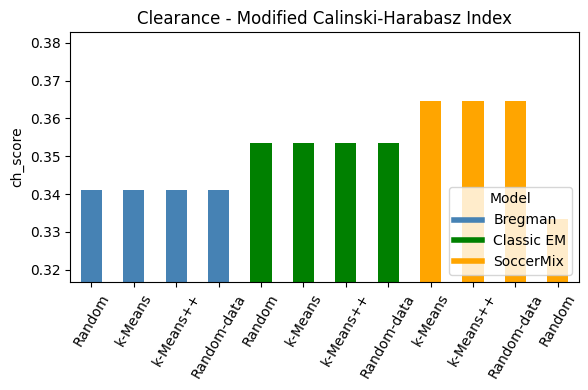

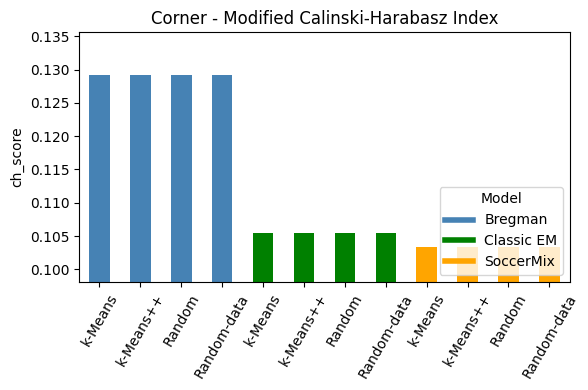

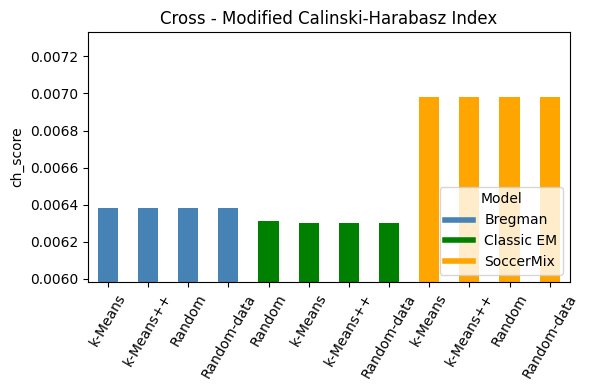

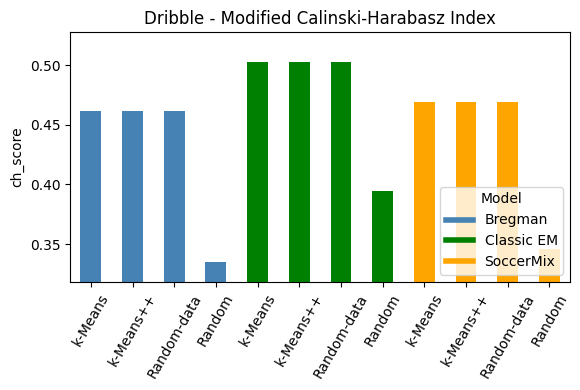

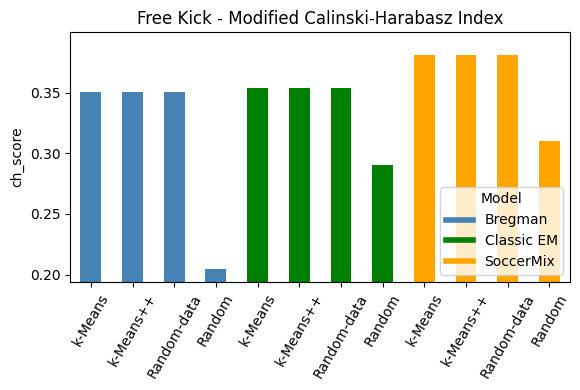

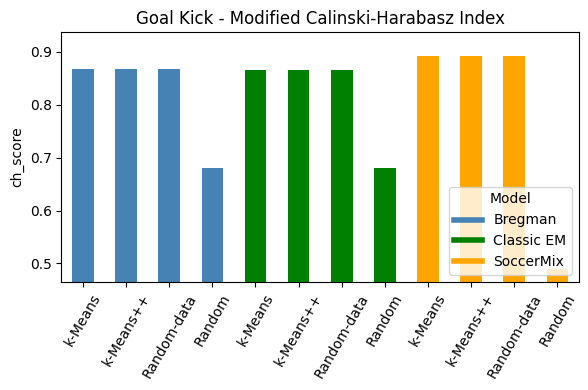

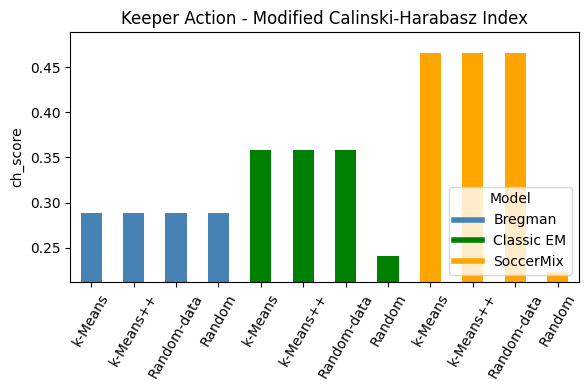

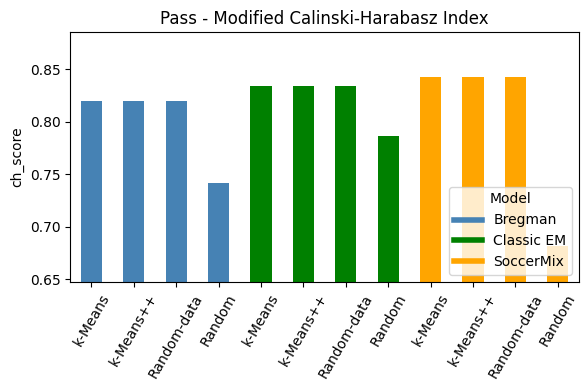

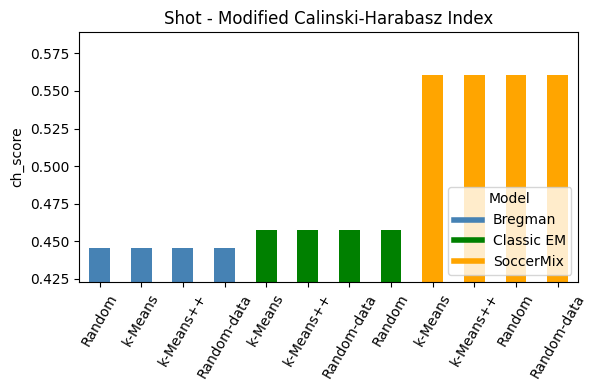

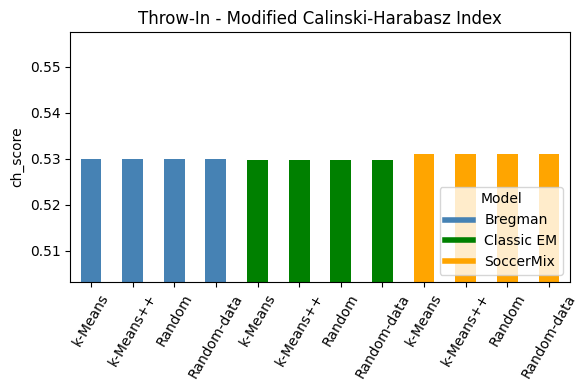

In [138]:
bar_plot_results(dir_summary, "ch_score")

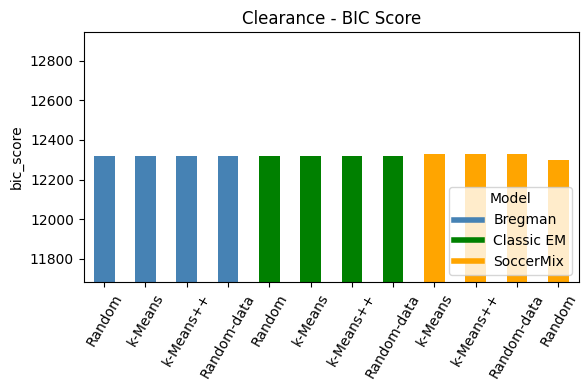

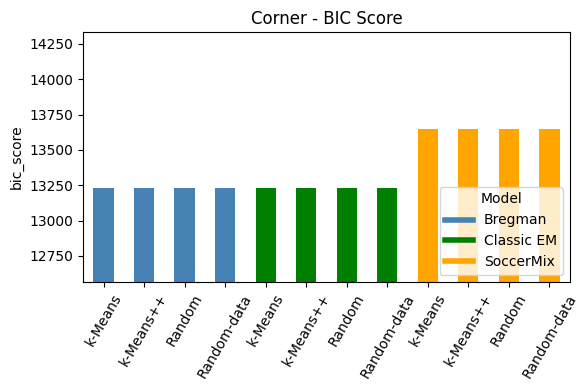

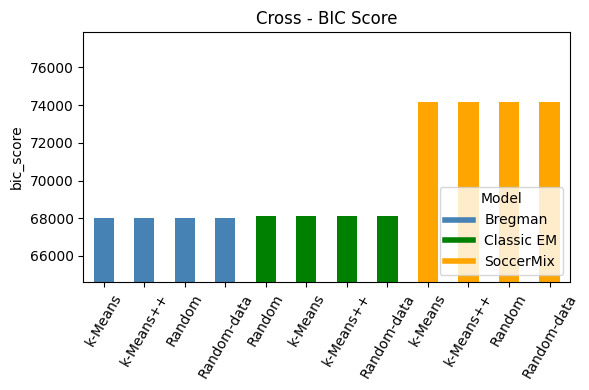

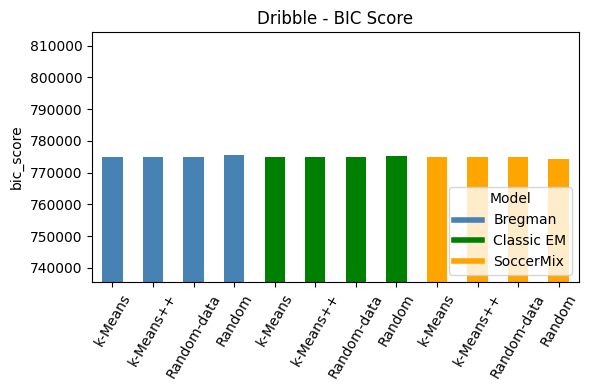

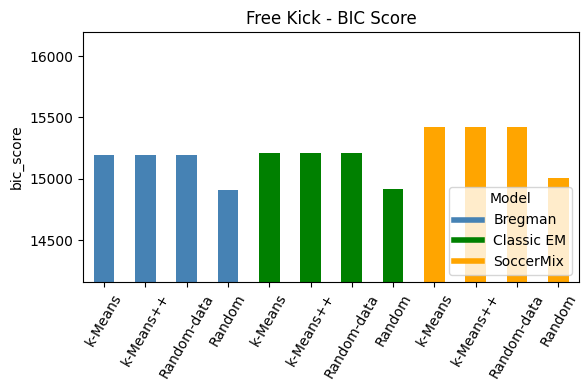

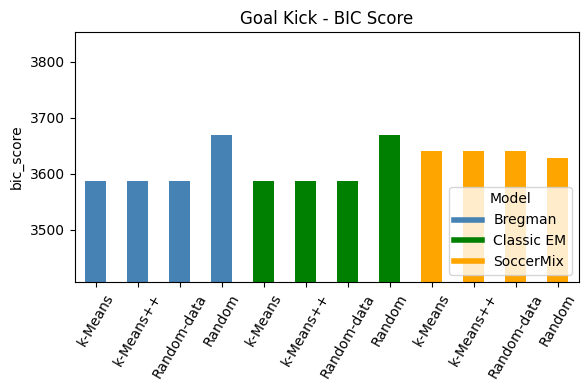

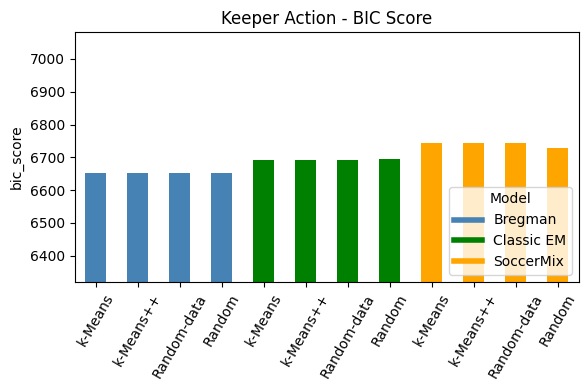

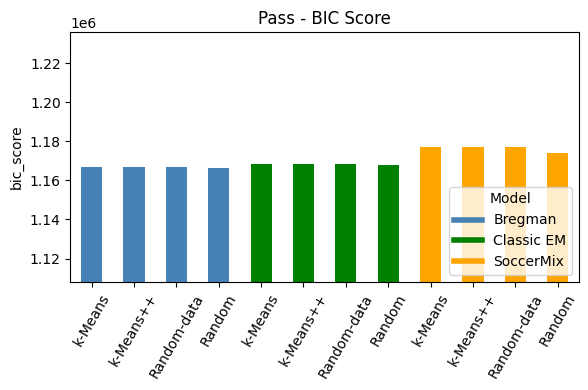

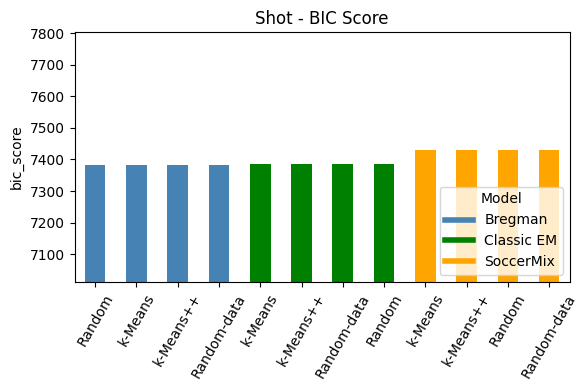

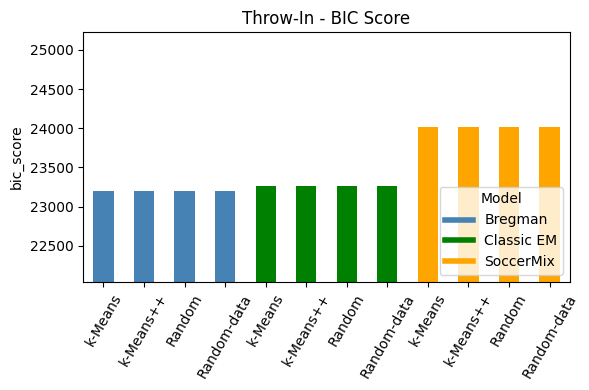

In [139]:
bar_plot_results(dir_summary, "bic_score")

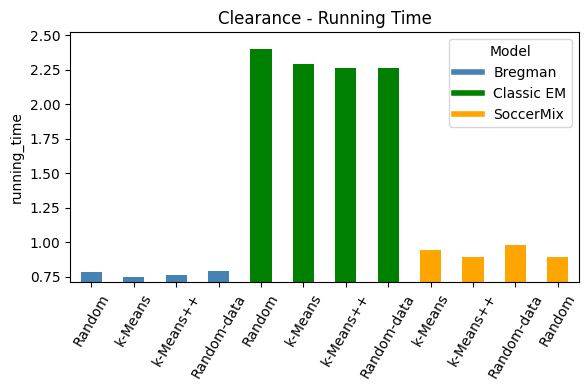

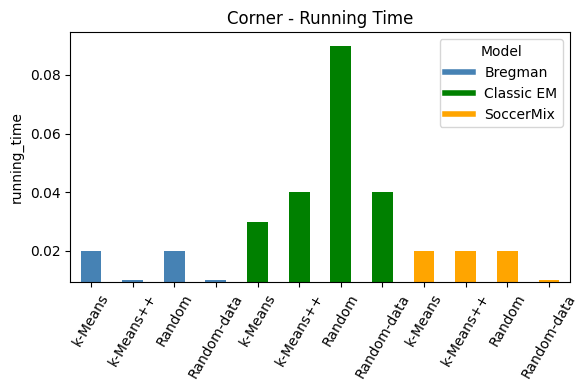

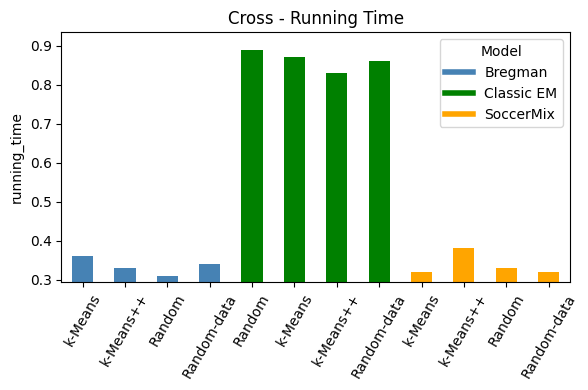

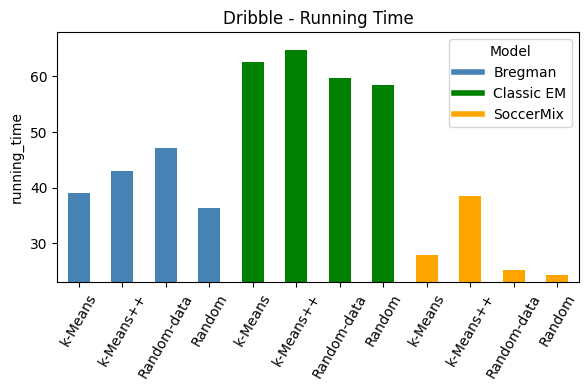

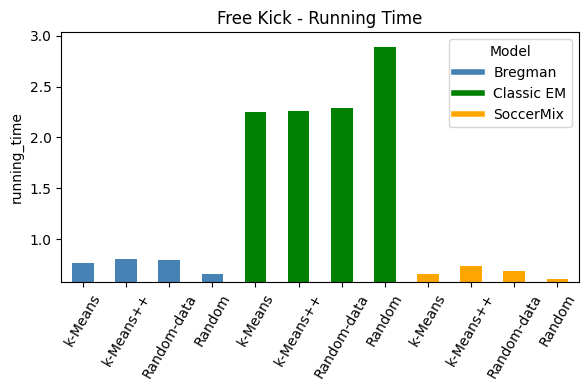

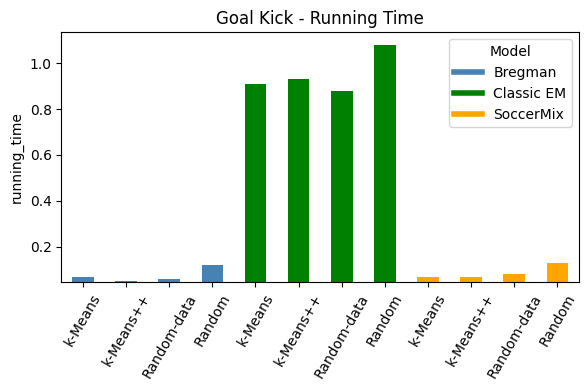

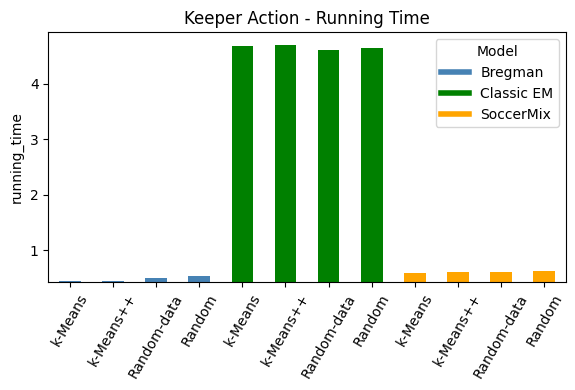

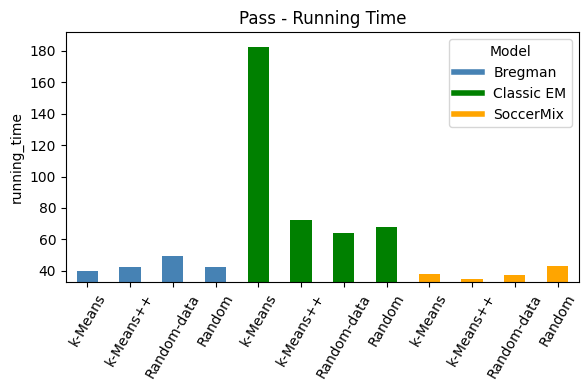

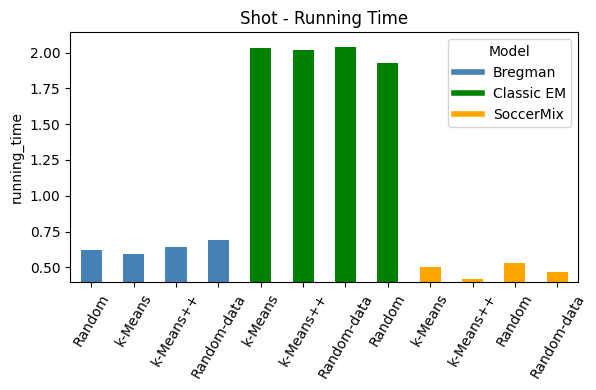

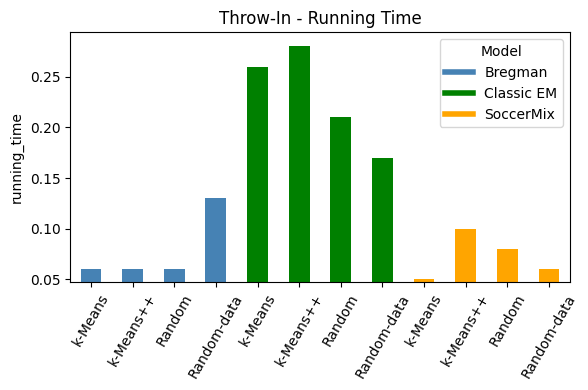

In [142]:
bar_plot_results(dir_summary, "running_time")

In [126]:
df = dir_summary.groupby(["model"]).sum().drop(columns=["action_type", "initialization"])
df.sort_values(by="ch_score", ascending=False, inplace=True)
df


,ch_score,count_loc_clusters,count_dir_clusters,bic_score,aic_score,running_time
model,,,,,,
approximation,17.43756,116,348,8433141.0,8430268.0,281.91
classic,16.94093,116,328,8372005.0,8369297.0,685.36
bregman,16.41924,116,304,8365768.0,8363154.0,351.81


In [150]:
def plot_models(action_types, loc_models, experiment):
    init_nice = {
        'random_from_data':'Random-data',
        'random':'Random',
        'k-means':'k-Means',
        'k-means++':'k-Means++'
    }
    action_nice = {
        'clearance': 'Clearance',
        'corner': 'Corner',
        'cross': 'Cross',
        'dribble': 'Dribble',
        'freekick': 'Free Kick',
        'goalkick': 'Goal Kick',
        'keeper_action': 'Keeper Action',
        'pass': 'Pass',
        'shot': 'Shot',
        'throw_in': 'Throw-In'
    }
    model_nice = {'bregman': 'Bregman EM',
                  'approximation': 'SoccerMix',
                  'classic': 'Classic EM'}

    for action_type in action_types:
        for method in ["bregman","approximation","classic"]:
            for init in ["k-means++", "k-means", "random", "random_from_data"]:
                vis.show_all_models(loc_models[action_type],
                                    experiment[method + "," + init][action_type],
                                    title=f"{action_nice[action_type]} - {model_nice[method]} with {init_nice[init]}",
                                    figsize=5)

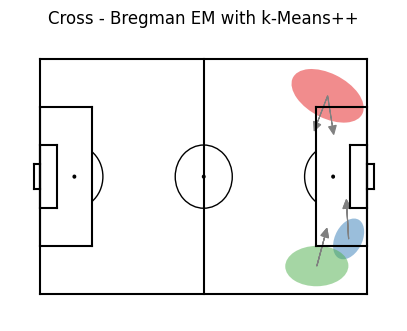

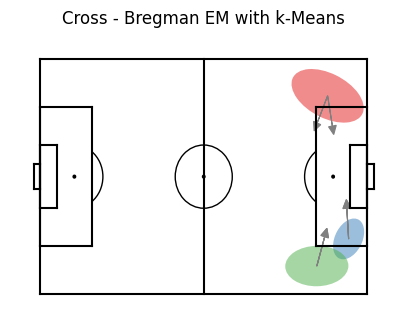

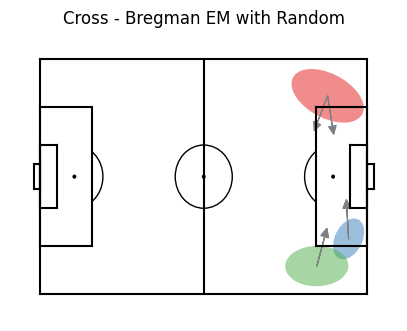

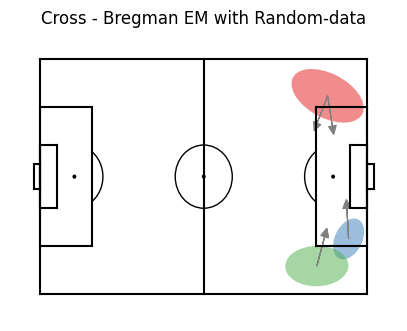

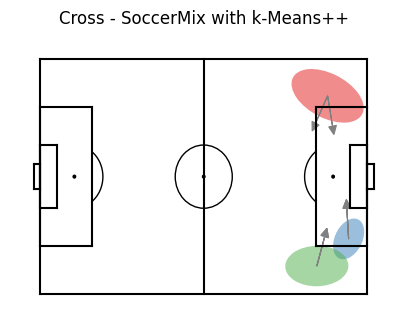

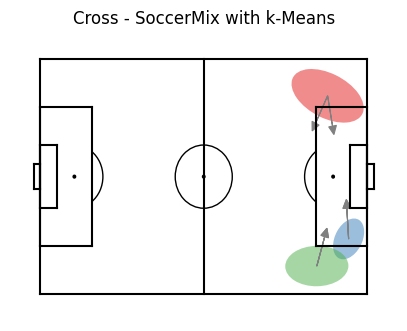

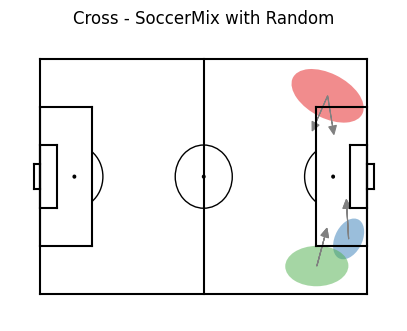

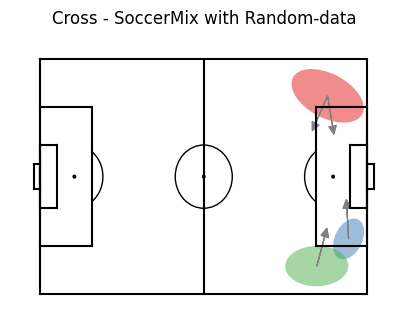

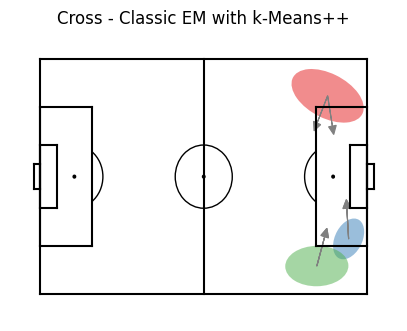

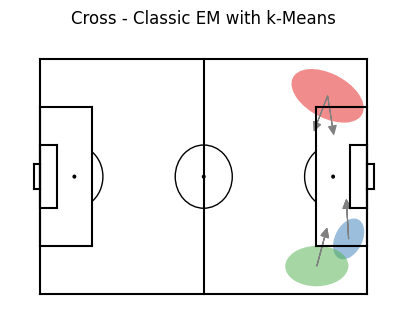

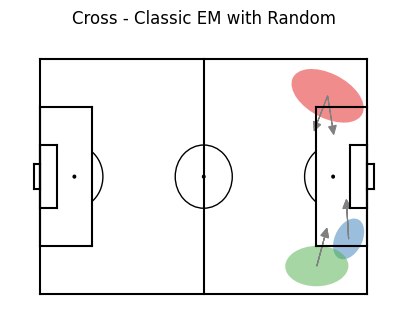

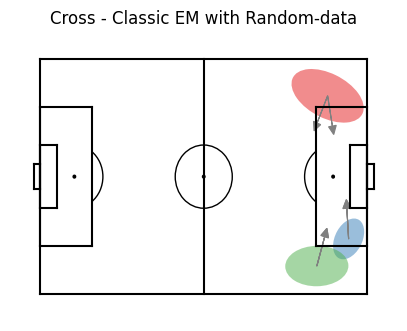

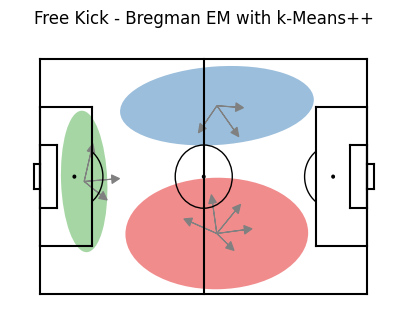

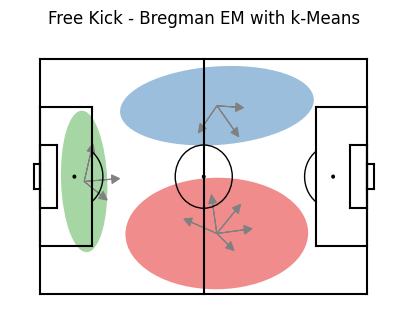

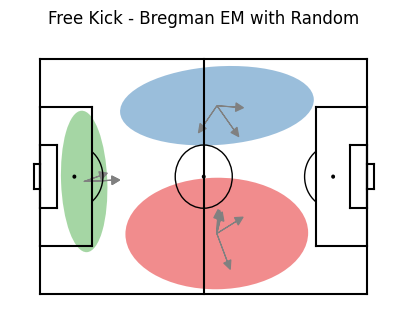

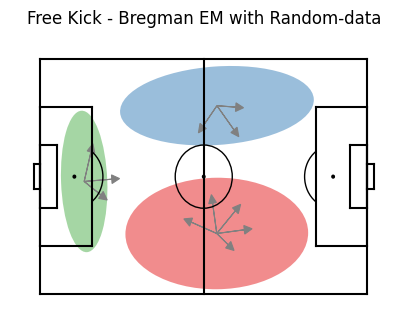

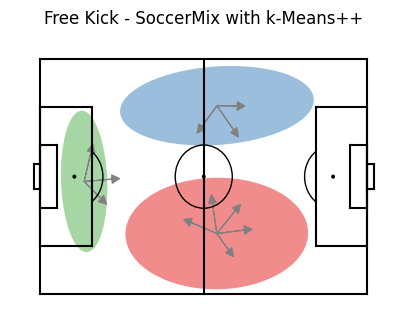

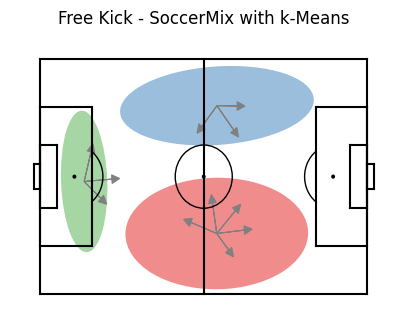

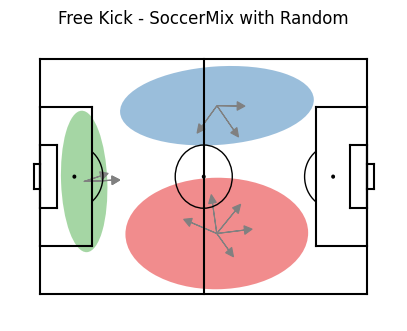

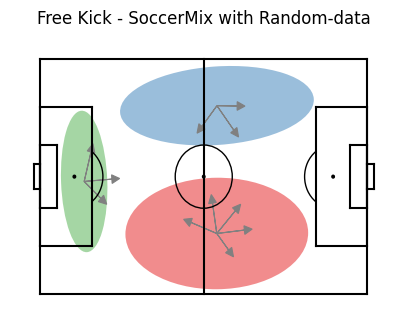

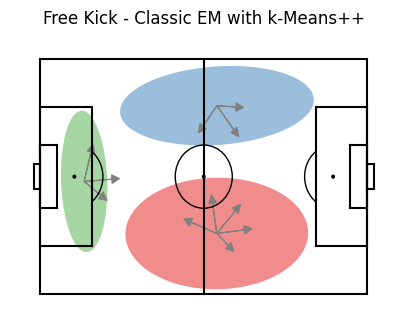

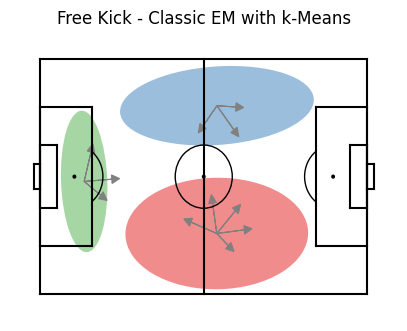

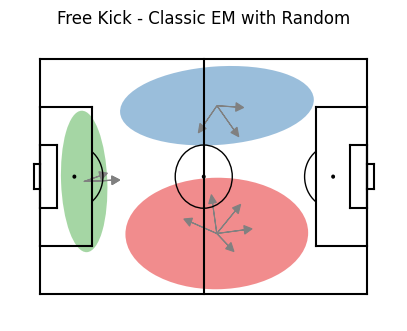

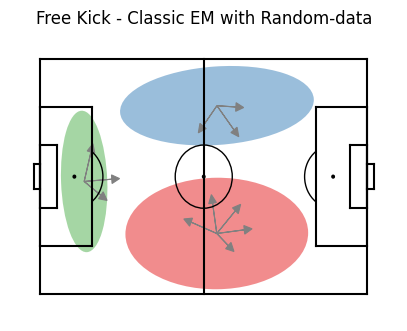

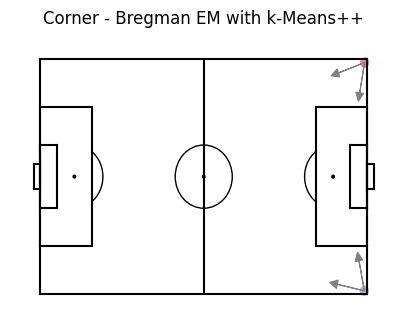

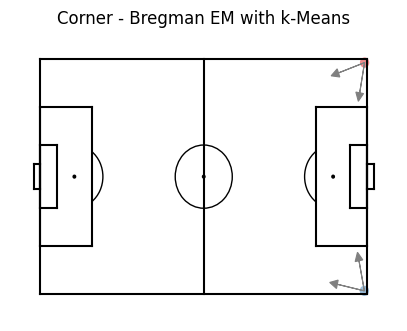

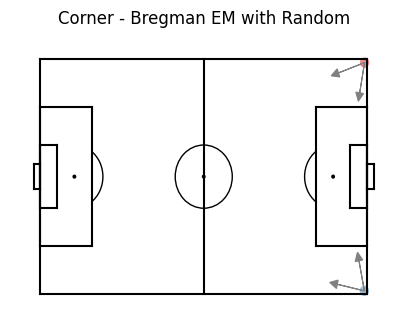

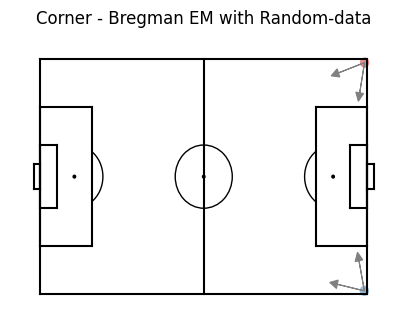

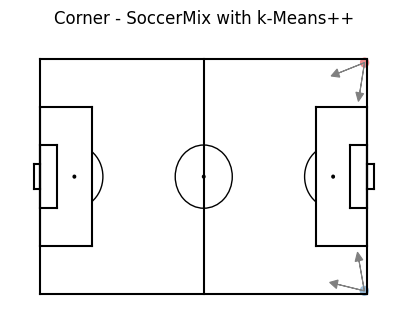

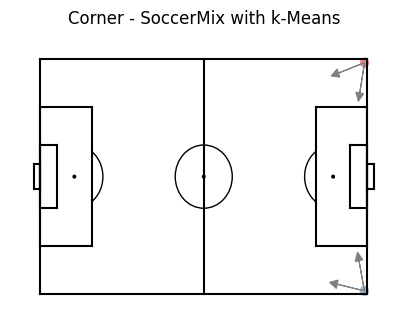

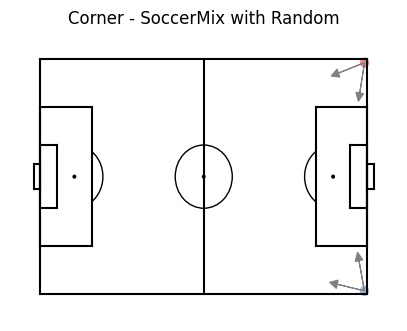

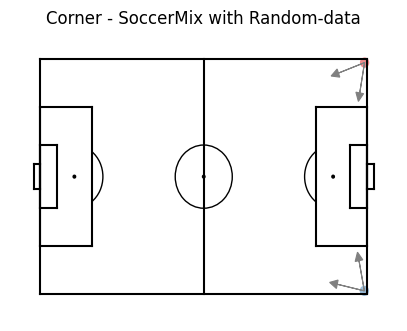

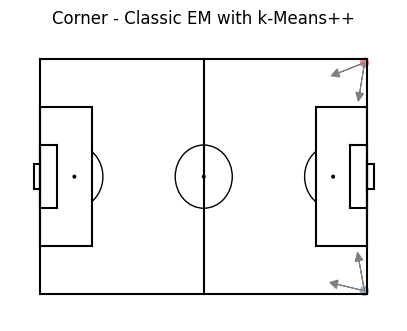

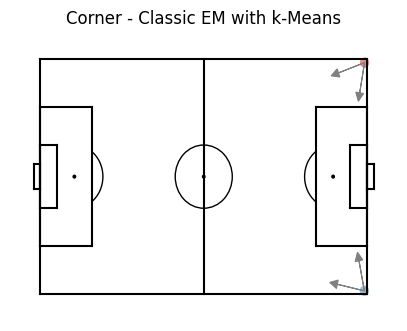

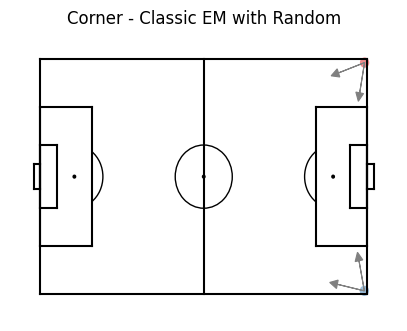

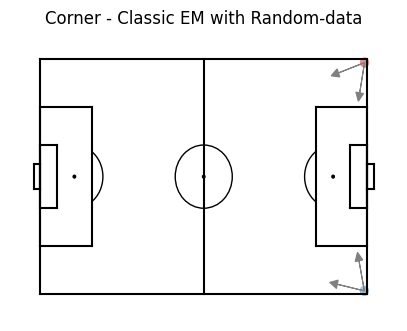

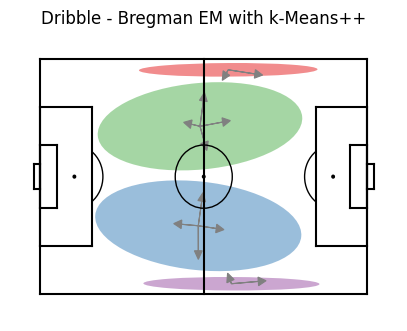

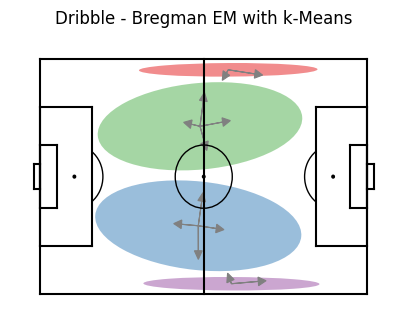

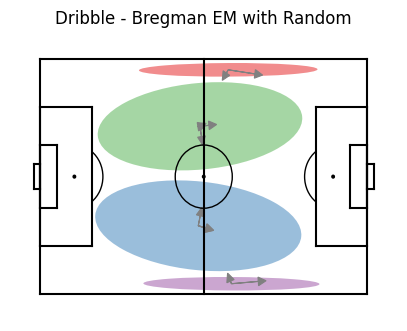

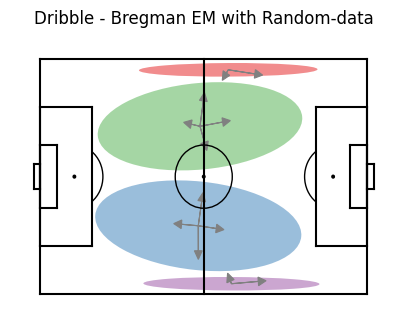

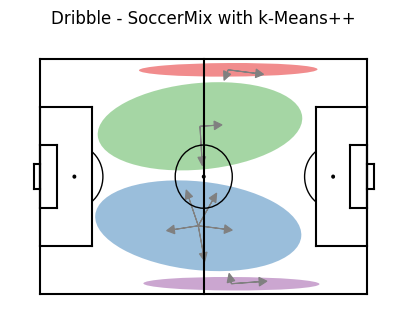

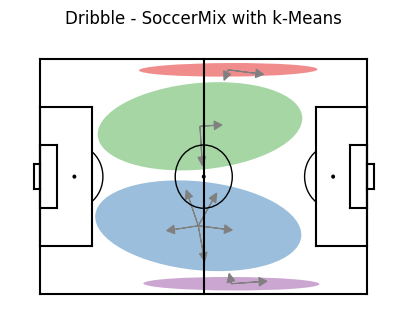

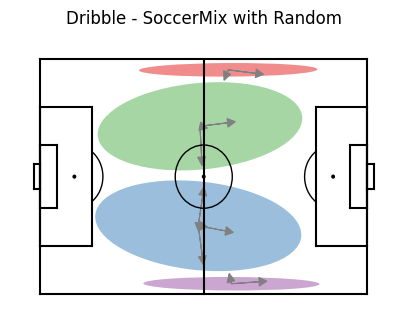

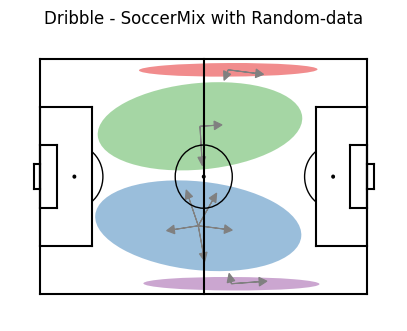

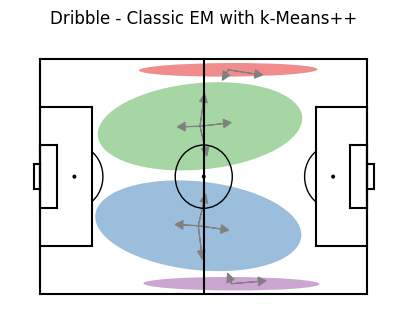

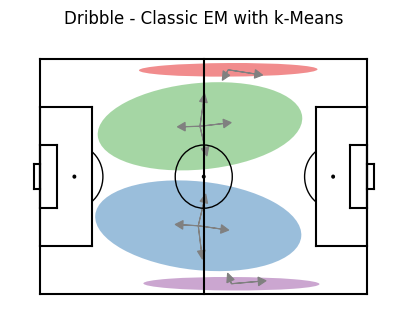

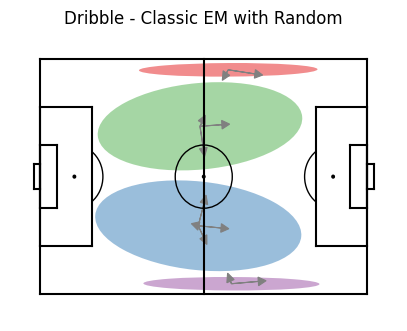

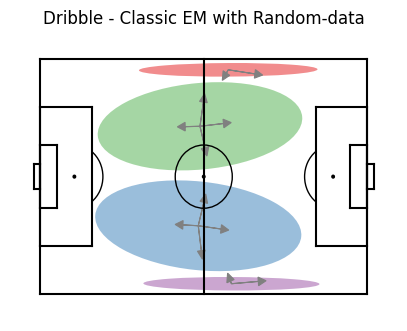

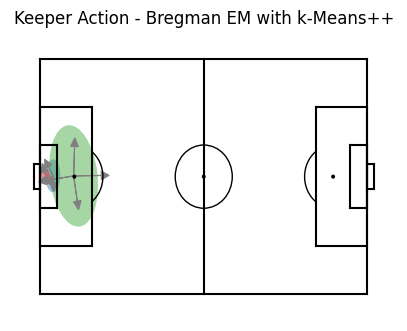

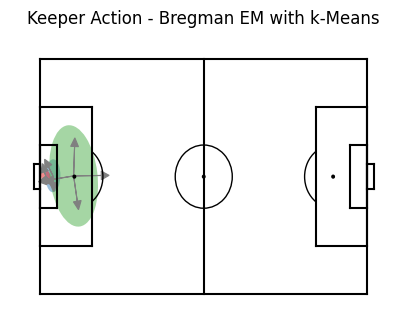

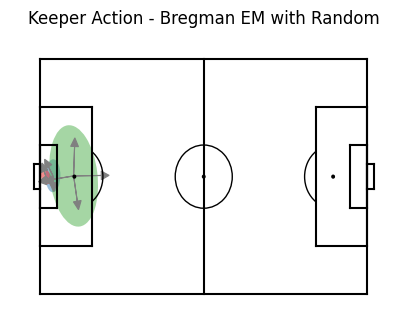

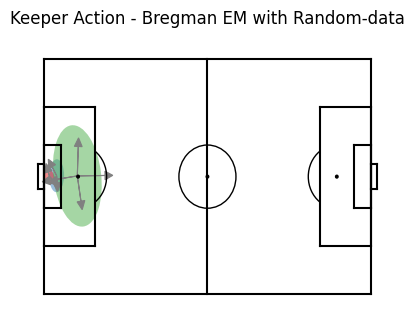

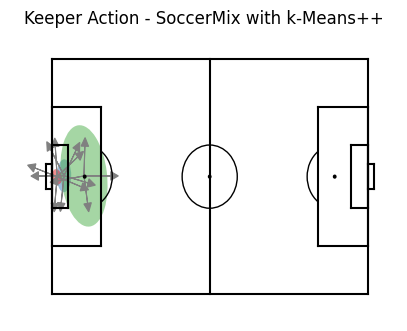

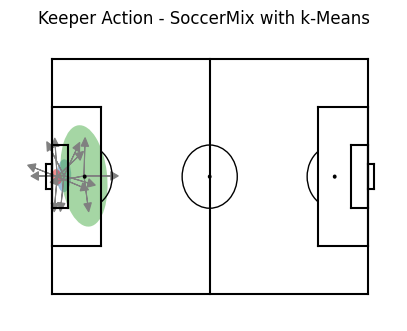

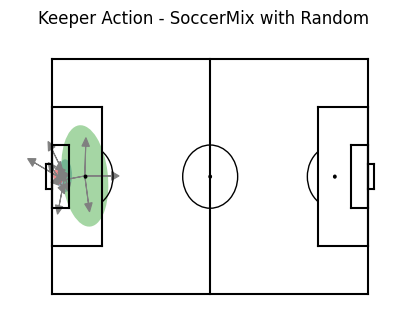

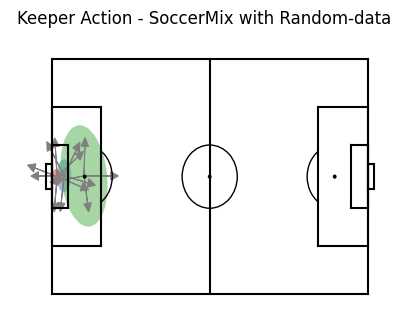

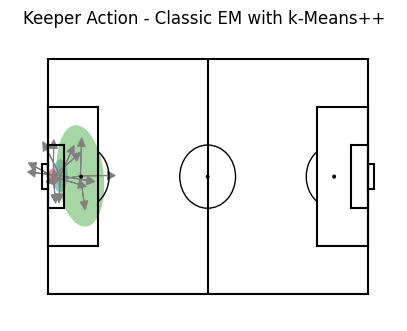

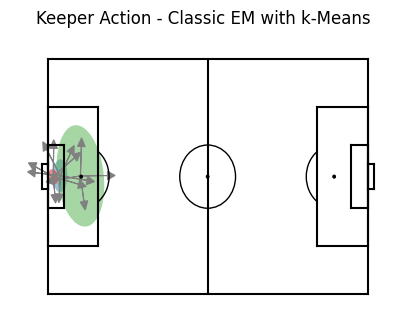

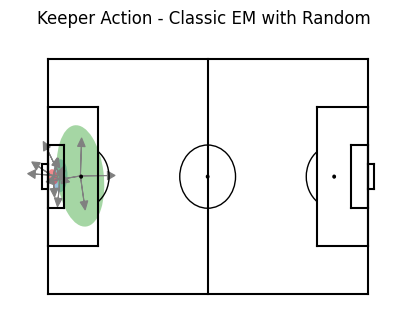

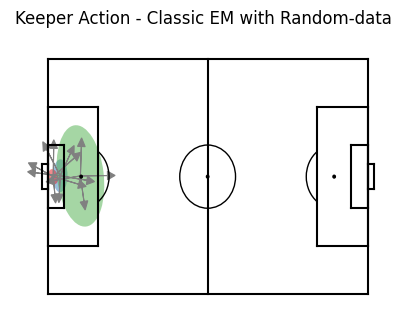

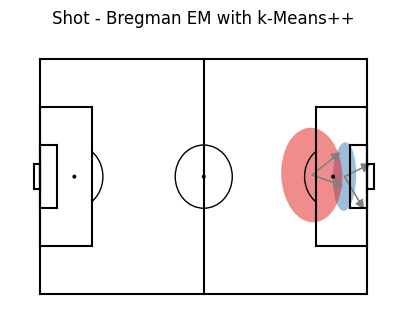

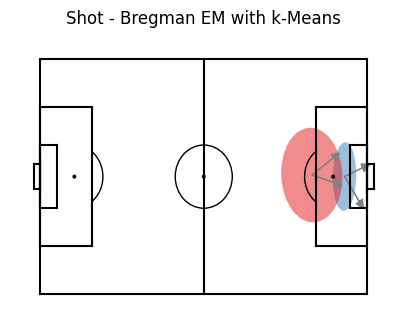

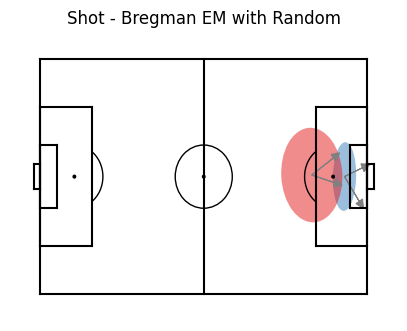

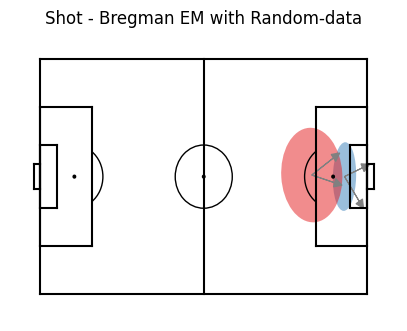

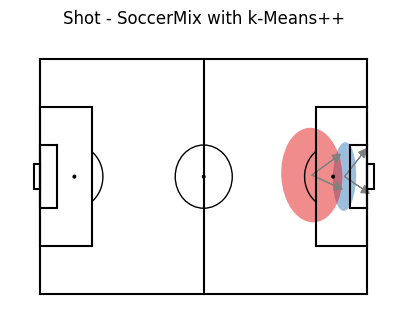

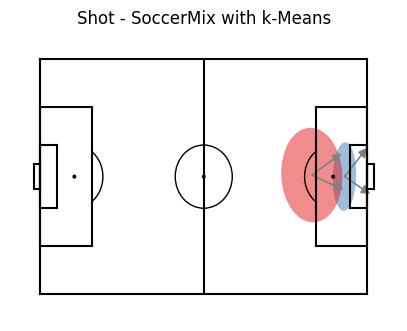

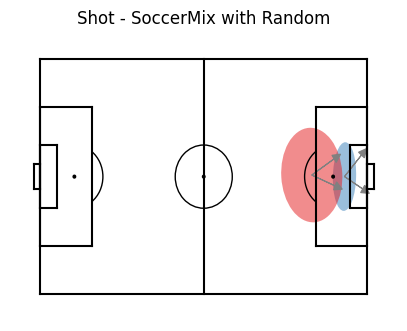

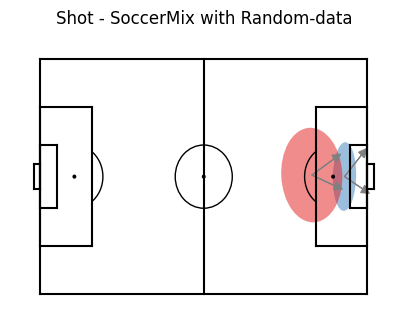

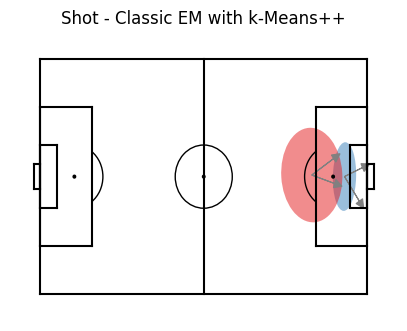

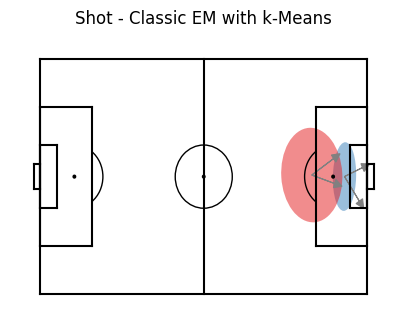

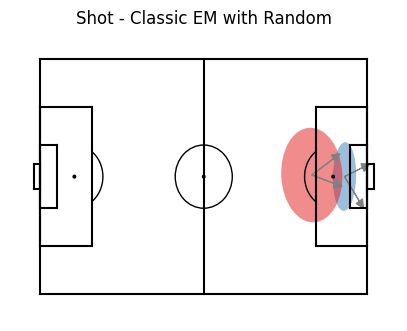

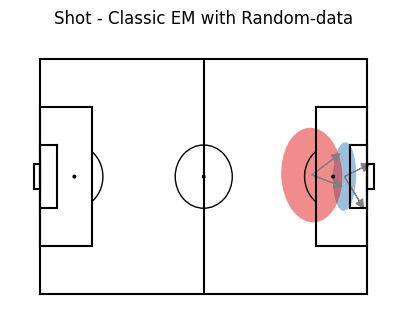

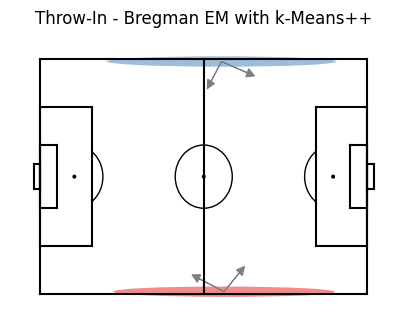

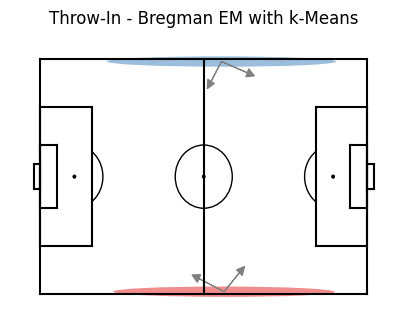

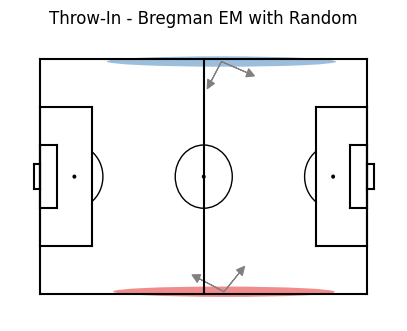

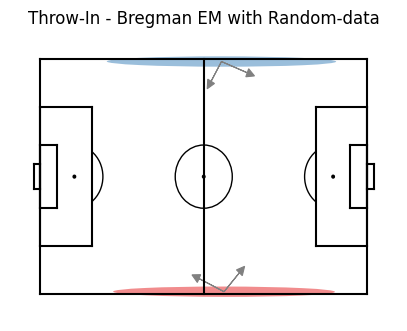

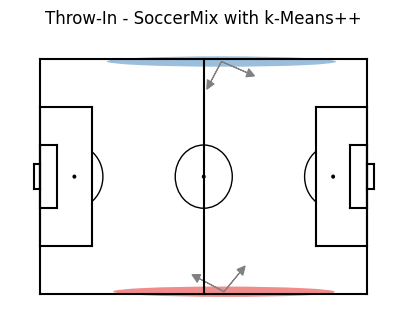

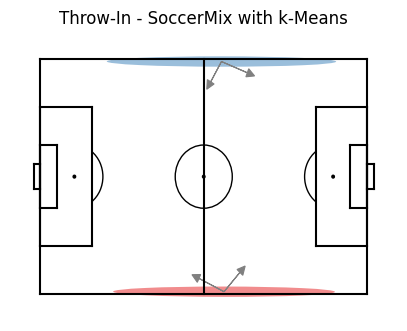

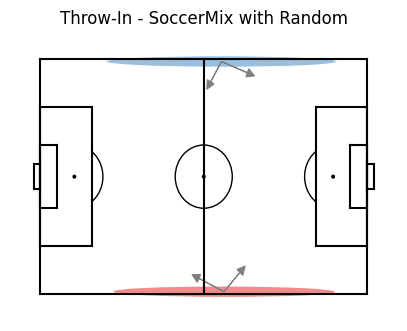

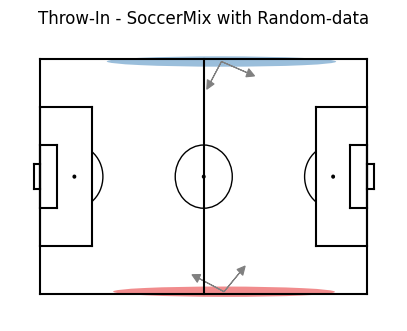

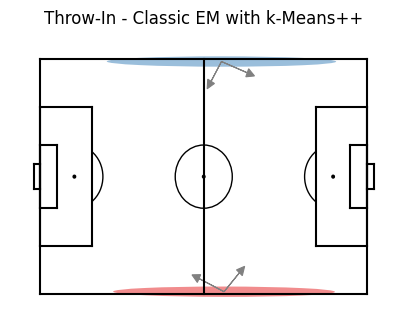

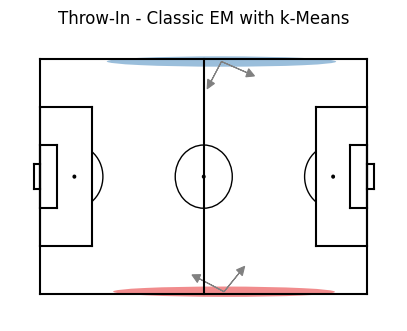

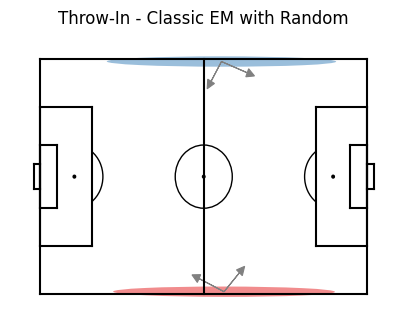

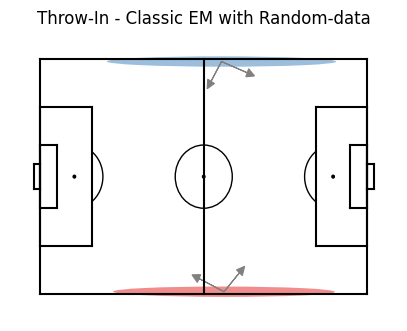

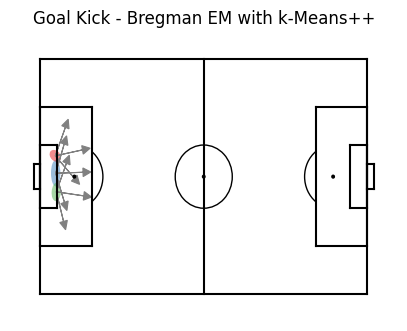

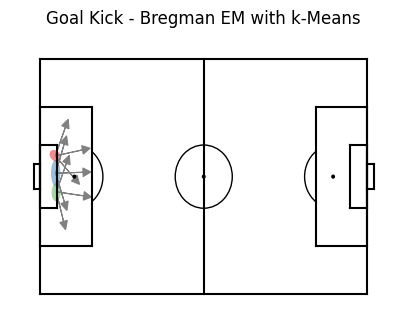

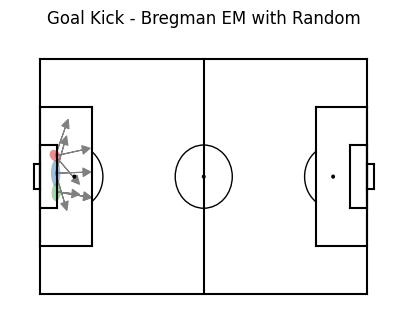

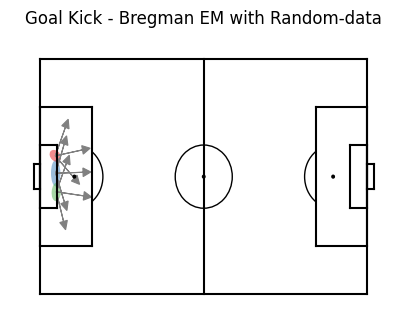

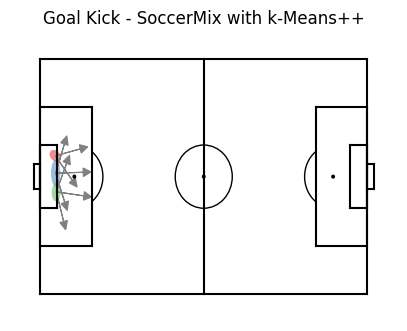

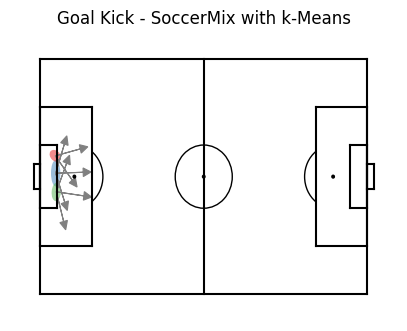

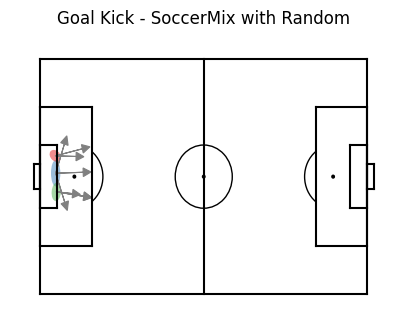

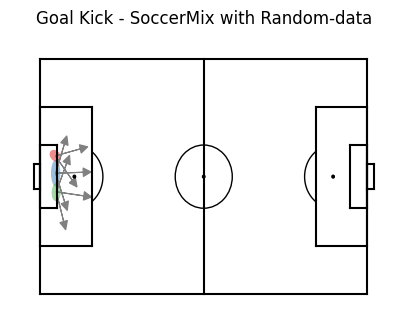

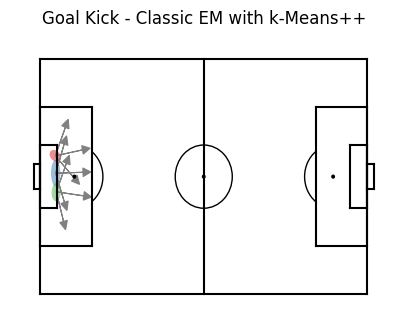

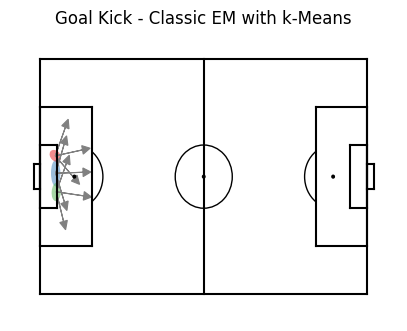

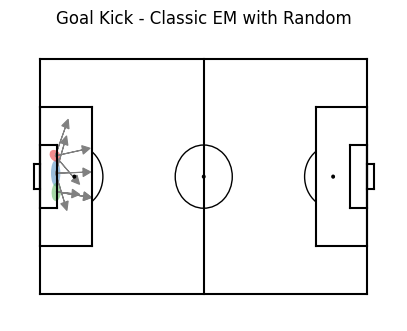

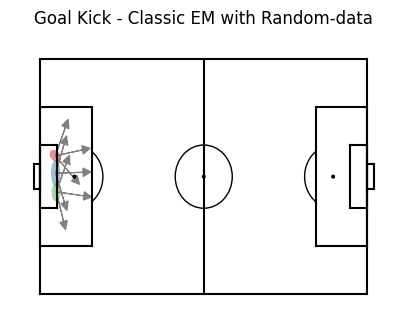

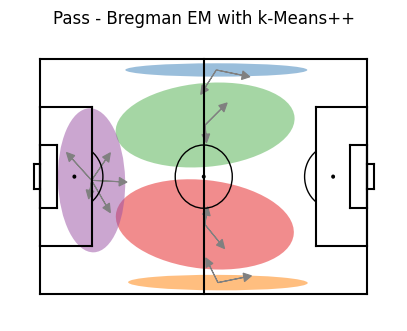

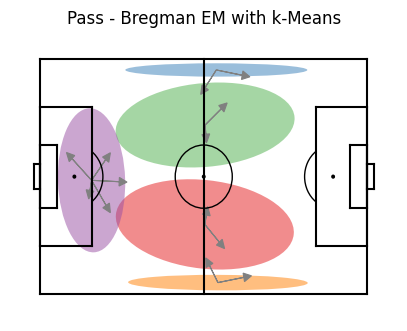

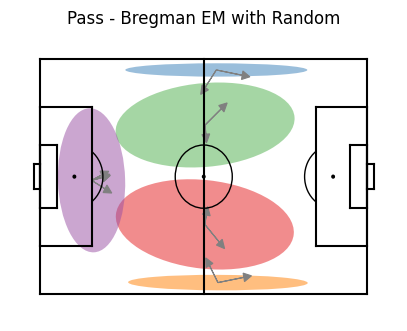

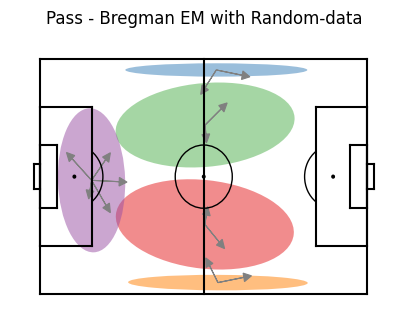

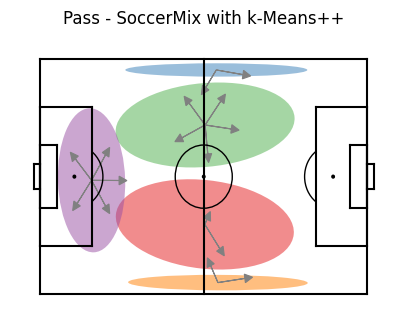

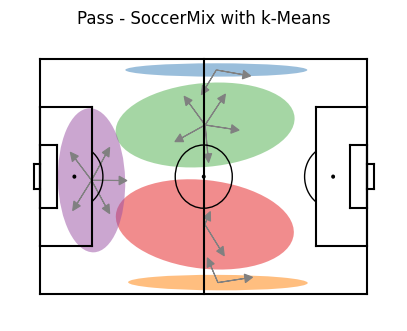

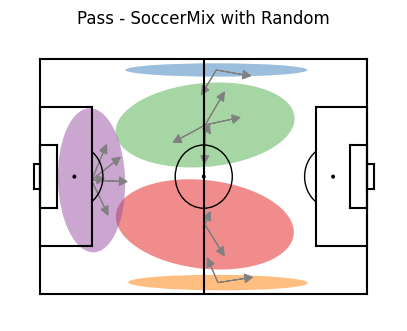

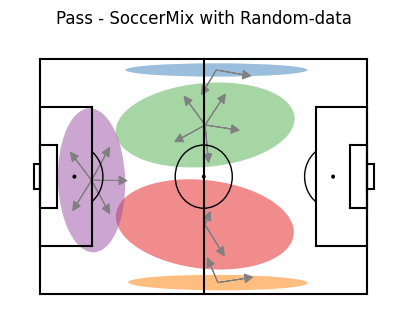

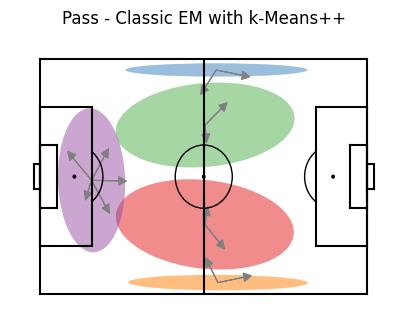

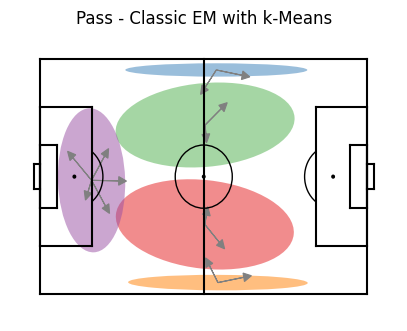

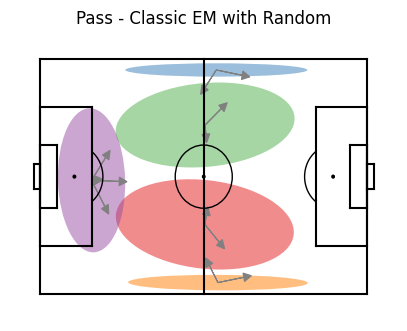

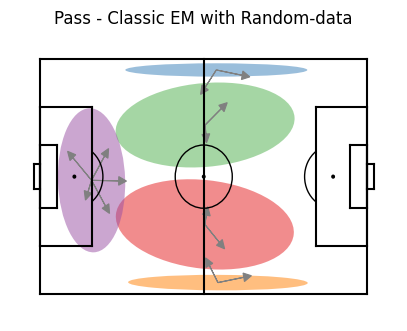

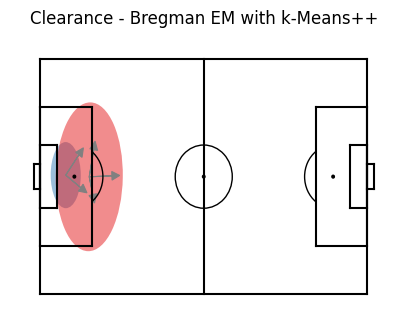

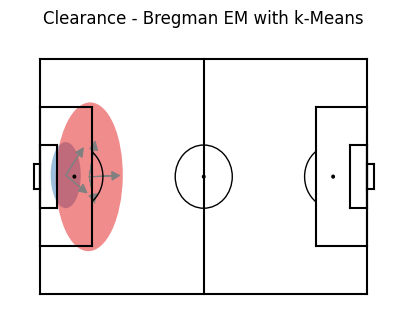

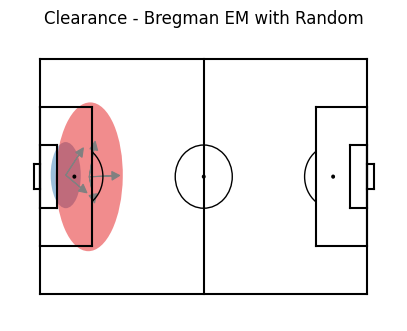

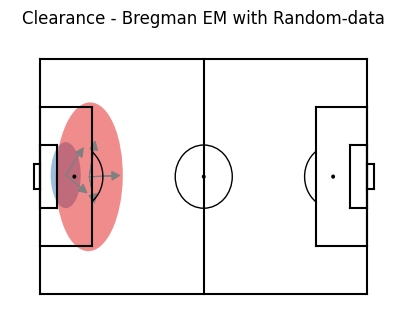

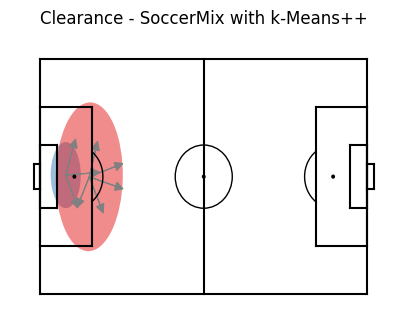

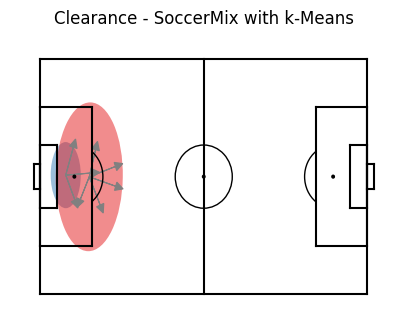

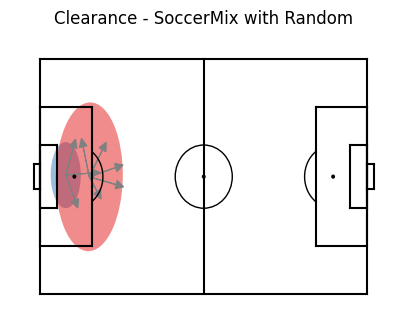

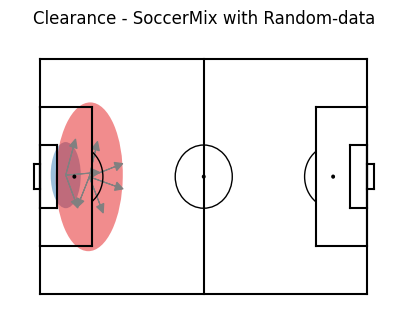

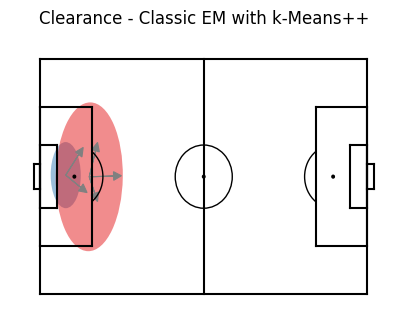

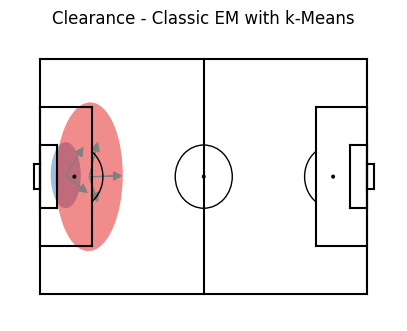

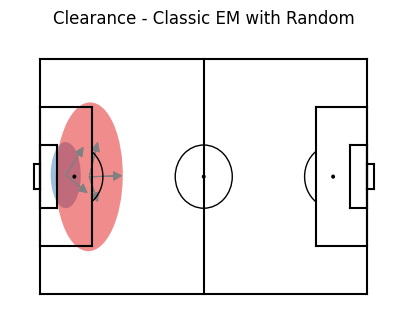

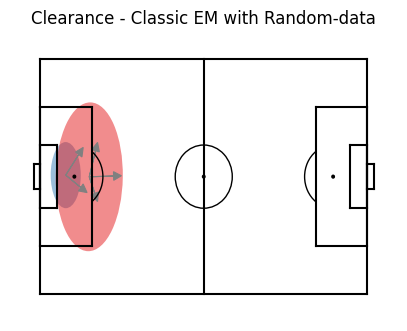

In [151]:
plot_models(action_types, loc_models, experiment)